In [4]:
# Breakdown sentiment by ChatGPT and human
# look at themes and topics of the 30 and 40 slections. Maybe too much emotion or common pattern
# Focus on the domain in which llm or human wins.
# look at complexitty of tweets and
# looka at null frames

# Domain topic analsysis on the frames between human and gpt
# Summary give exampels of emotional tweets for that
# Percentage of verbs, adj, nouns, in a tweet
#

###########################################
# Analyzing the number of human responses #
# vs ChatGPT responses selected.          #
###########################################

import json

chatgpt_selected = 0
human_selected = 0

i=0

input_messages: list = []

gpt_selected_msgs: list = []
human_selected_msgs: list = []

# A list of tweets which yielded atleast 1 null answer choice.
null_prompts = []

# Open your NDJSON file
with open('humanpref4.ndjson', 'r') as file:
    for line in file:
        try:
            data_dict = json.loads(line)  # Parse each line as JSON

            row_data_str = data_dict.get('data_row', {}).get('row_data', '')

            if row_data_str:
                # Parse the stringified JSON in 'row_data'
                row_data_dict = json.loads(row_data_str)

                # Now extract modelOutputs from the parsed row_data
                model_outputs = row_data_dict['modelOutputs']

                # Save the social media posts for later
                input_messages.append(row_data_dict.get('messages')[0]['content'])

                # Identify responses belonging to chatGPT4o and others
                chatgpt4o_response = None
                other_response = None

                for output in model_outputs:
                    if output.get('modelConfigName') == 'ChatGPT4o':
                        chatgpt4o_response = output
                    else:
                        other_response = output

                    if output.get('content') == "None" and (row_data_dict.get('messages')[0]['content']) not in null_prompts:
                        null_prompts.append( row_data_dict.get('messages')[0]['content'] )


                # If we have both a chatGPT4o response and another response
                if chatgpt4o_response and other_response:
                    # Extract the radio answer
                    id = ""
                    for x in data_dict['projects']:
                        id = x
                        break

                    i+=1

                    classi = data_dict['projects'][id]['labels']

                    if len(classi) > 0:
                        x = classi[0]['annotations']['classifications']

                        if len(x) > 0:
                            radio_answer = x[0].get('radio_answer')

                            # Check if the "name" or "value" matches the chatGPT4o response
                            is_name_match = radio_answer.get('name') == chatgpt4o_response.get('title')[-1]
                            is_value_match = radio_answer.get('value') == chatgpt4o_response.get('title')[-1]

                            if radio_answer.get('name') == chatgpt4o_response.get('title')[-1]:
                                chatgpt_selected += 1
                                gpt_selected_msgs.append(row_data_dict.get('messages')[0]['content'])
                            if radio_answer.get('name') == other_response.get('title')[-1]:
                                human_selected_msgs.append(row_data_dict.get('messages')[0]['content'])
                                human_selected += 1

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

print("ChatGPT selected ", chatgpt_selected)
print("Human selected ", human_selected)

print(input_messages)


"""OPTIONAL: Truncate the Null Prompts to ignore blanks. """
null_prompts = [x for x in null_prompts if len(x) > 4]

ChatGPT selected  63
Human selected  68
['Biden: "There\'s not a single solitary Biden man that is as old, uhh, younger than any Biden woman."\r\n https://t.co/iCgHFtYM0f', 'RT @BucksCoBeacon: Newtown Community Shuts Down Hateful Propaganda Movie Screening | Right-wing parents wanted to show a doc that claims public school teachers teach kids “X-rated sex acts” &amp; pushes other conspiracies often heard at #BucksCounty school board meetings. READ: https://t.co/7sdex6iVAD https://t.co/tCgD4xMZwj', 'RT @JeremiahSladeck: “Chronology is an enemy of autocracy” might be one of the best sentences ever written. https://t.co/AHTeNwVxxm', 'Trump 2024? 60% of Voters Say ‘No’DeSantis favorability beats Trump significantly in every demographic, especially when comparing Very Unfavorables.\r\n\r\nBut Republican and Independent voters are only 4 points more likely to say DeSantis should run than Trump.\r\n\r\nhttp://bit.ly/3tBtWqm', 'Voters Still Concerned About High Gas PricesVery Concerned about g

In [5]:
###########################################
# Analyzing the sentiment of each input.  #
#                                         #
###########################################

# Add more than positive and negative

from transformers import pipeline

results: list = []

# Initialize the pipeline
sentiment_analyzer = pipeline('sentiment-analysis')

# Input for analysis
for text in input_messages:
    # Perform sentiment analysis

    result = sentiment_analyzer(text)

    results.append(result[0]['label'])

positive_results = results.count("POSITIVE")
negative_results = results.count("NEGATIVE")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
###########################################
# Extract emotional sentiments from the   #
# tweets which go beyond + and - .        #
###########################################

from collections import Counter

print(human_selected_msgs)
print(gpt_selected_msgs)

# Load a pre-trained emotion classification model
emotion_pipeline = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

# Analyze emotions in a text
# text = "I'm so excited about my new job, but a bit nervous too."

# Initialize a counter to tally the emotions
gpt_emotion_counts = Counter()
human_emotion_counts = Counter()

# Loop through each text and get the prevailing emotion
for text in gpt_selected_msgs:
    result = emotion_pipeline(text)
    # Find the emotion with the highest score
    prevailing_emotion = max(result[0], key=lambda x: x['score'])
    # Increment the count for the prevailing emotion
    gpt_emotion_counts[prevailing_emotion['label']] += 1

# Loop through each text and get the prevailing emotion
for text2 in human_selected_msgs:
    result = emotion_pipeline(text2)
    # Find the emotion with the highest score
    prevailing_emotion = max(result[0], key=lambda x: x['score'])
    # Increment the count for the prevailing emotion
    human_emotion_counts[prevailing_emotion['label']] += 1

# Output the tally of emotions
print("GPT emotion counts:")
for emotion, count in sorted(gpt_emotion_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{emotion}: {count}")

# Output the tally of emotions
print("\nHuman emotion counts:")
for emotion, count in sorted(human_emotion_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{emotion}: {count}")



['Biden: "There\'s not a single solitary Biden man that is as old, uhh, younger than any Biden woman."\r\n https://t.co/iCgHFtYM0f', 'RT @BucksCoBeacon: Newtown Community Shuts Down Hateful Propaganda Movie Screening | Right-wing parents wanted to show a doc that claims public school teachers teach kids “X-rated sex acts” &amp; pushes other conspiracies often heard at #BucksCounty school board meetings. READ: https://t.co/7sdex6iVAD https://t.co/tCgD4xMZwj', 'Trump 2024? 60% of Voters Say ‘No’DeSantis favorability beats Trump significantly in every demographic, especially when comparing Very Unfavorables.\r\n\r\nBut Republican and Independent voters are only 4 points more likely to say DeSantis should run than Trump.\r\n\r\nhttp://bit.ly/3tBtWqm', 'S/o to @DianaGlebova for this banger🔥  QT @greg_price11: Reporter: "Does President Biden want more migrants to come to Delaware?"\r\n\r\nJean-Pierre: "I don\'t even understand that question." https://t.co/1bJ9I8ISiW', 'More Voters Favor Repu

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


GPT emotion counts:
fear: 24
neutral: 23
anger: 8
surprise: 4
sadness: 3
joy: 1

Human emotion counts:
fear: 20
neutral: 19
anger: 13
sadness: 7
surprise: 6
joy: 3


In [7]:
#######################################################################
# Calculate average TTR of datasets to determine lexical complexity.  #
# Calculate the readabiliity of the dataset and compare them.         #
#######################################################################

# Use other matrix than flesch to see if there are other difference on the TTR and Flesch
# Dependency parse trees are an example, Automated readbility index, Dale Chall

import re

def syllable_count(word):
    word = word.lower()
    vowels = "aeiouy"
    syllables = re.findall(r'[aeiouy]+', word)
    count = len(syllables)

    if word.endswith("e"):
      count -= 1

    if word.endswith("le") and len(word) > 2 and word[-3] not in vowels:
      count += 1

    if count <= 0:
      count = 1
    return count


from nltk import FreqDist
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import sent_tokenize


nltk.download('punkt')
humanTTRmean = 0
gptTTRmean = 0
hf = 0
gf = 0

for text in human_selected_msgs:
    tokens = word_tokenize(text)
    unique_tokens = set(tokens)
    ttr = len(unique_tokens) / len(tokens)
    humanTTRmean += ttr

    sentences = sent_tokenize(text)

    total_words = len(tokens)
    total_sentences = len(sentences)
    total_syllables = sum([syllable_count(word) for word in tokens])

    hf += 206.835 - (1.015 * (total_words / total_sentences)) - (84.6 * (total_syllables / total_words))

for text in gpt_selected_msgs:
    tokens = word_tokenize(text)
    unique_tokens = set(tokens)
    ttr = len(unique_tokens) / len(tokens)
    gptTTRmean += ttr

    sentences = sent_tokenize(text)

    total_words = len(tokens)
    total_sentences = len(sentences)
    total_syllables = sum([syllable_count(word) for word in tokens])

    gf += 206.835 - (1.015 * (total_words / total_sentences)) - (84.6 * (total_syllables / total_words))

humanTTRmean = humanTTRmean / len(human_selected_msgs)
gptTTRmean = gptTTRmean / len(gpt_selected_msgs)

# Type-Token Ratio (TTR): This metric measures the ratio of unique words (types)
# to the total number of words (tokens) in a text, providing an
# indication of vocabulary variety.
print("Human TTR mean: ", humanTTRmean)
print("GPT TTR mean: ", gptTTRmean, "\n")

# Flesch Readabilty score, higher the better.
print("Human Flesch score: ", hf/len(human_selected_msgs))
print("GPT Flesch score: ", gf/len(gpt_selected_msgs))

nf = 0
for text in null_prompts:
    tokens = word_tokenize(text)
    unique_tokens = set(tokens)
    ttr = len(unique_tokens) / len(tokens)
    gptTTRmean += ttr

    sentences = sent_tokenize(text)

    total_words = len(tokens)
    total_sentences = len(sentences)
    total_syllables = sum([syllable_count(word) for word in tokens])

    nf += 206.835 - (1.015 * (total_words / total_sentences)) - (84.6 * (total_syllables / total_words))

print("Null Flesch score: ", nf/len(null_prompts), "\n")




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Human TTR mean:  0.8407022711433938
GPT TTR mean:  0.8295647514297347 

Human Flesch score:  52.99895511335737
GPT Flesch score:  52.158334499952254
Null Flesch score:  65.96611534019117 



In [8]:
average_length = lambda lst: sum(len(entry) for entry in lst) / len(lst) if lst else 0
print("Average Length of null prompts:", average_length(null_prompts))
print("Average Length of human selected msgs:", average_length(human_selected_msgs))
print("Average Length of gpt selected msgs:", average_length(gpt_selected_msgs))

print("\nTweets which resulted in one or more selections being \"None\".")
print(null_prompts)

Average Length of null prompts: 133.2826086956522
Average Length of human selected msgs: 243.61764705882354
Average Length of gpt selected msgs: 245.77777777777777

Tweets which resulted in one or more selections being "None".
['RT @visionsurreal: @RepRiggleman @gal_suburban @jennycohn1 @brucewilson @Liz_Cheney 👆 BONUS #4a:\r\n\r\nRe: Every Legal Vote\'s site, despite Wallnau claiming he "just saw this tonight" on 11/12/20, how much shall we bet he was already familiar w/ it?\r\n\r\nAfter all, on 11/10, Wallnau posted the phrase "Count Every Legal Vote" along w/ a link to his book God\'s Chaos Code. https://t.co/WNez1cEdDK', 'RT @Phillies: WHO ARE WE FREAKING TALKING ABOUT?!\r\n\r\n#RingTheBell https://t.co/alLXBU91qJ', 'Special Counsel Probe of Trump Is Politically Motivated, Most Voters Say\r\n\r\nhttp://bit.ly/3Bbscbx', 'Jean-Pierre calls the Nobel Prize the "Noble Prize" four times. https://t.co/Zw0TRNxqiz', 'FIRST INNING BRYCE BOMB #RedOctober \r\n https://t.co/P2BcTEsBPq', 'Phill

In [9]:
"""WEEK OF OCT 17TH"""

'WEEK OF OCT 17TH'

In [10]:
import spacy

# Load the spaCy model for English
nlp = spacy.load("en_core_web_sm")


def count(text: list):
    noun_percentage = 0
    verb_percentage = 0
    adj_percentage  = 0

    for x in text:
        # Process the text with spaCy
        doc = nlp(x)

        # Count POS occurrences
        total_tokens = len(doc)
        noun_count = sum(1 for token in doc if token.pos_ == "NOUN")
        verb_count = sum(1 for token in doc if token.pos_ == "VERB")
        adj_count = sum(1 for token in doc if token.pos_ == "ADJ")

        # Calculate percentages
        noun_percentage += (noun_count / total_tokens) * 100
        verb_percentage += (verb_count / total_tokens) * 100
        adj_percentage += (adj_count / total_tokens) * 100

    noun_percentage = noun_percentage / len(text)
    verb_percentage = verb_percentage / len(text)
    adj_percentage = adj_percentage / len(text)

    print(f"Percentage of nouns: {noun_percentage:.2f}%")
    print(f"Percentage of verbs: {verb_percentage:.2f}%")
    print(f"Percentage of adjectives: {adj_percentage:.2f}%\n")

print("Human Selected Messages")
count(human_selected_msgs)

print("GPT Selcted Messages")
count(gpt_selected_msgs)

print("Null Prompts")
count(null_prompts)

Human Selected Messages
Percentage of nouns: 16.15%
Percentage of verbs: 10.27%
Percentage of adjectives: 4.80%

GPT Selcted Messages
Percentage of nouns: 15.39%
Percentage of verbs: 9.92%
Percentage of adjectives: 6.41%

Null Prompts
Percentage of nouns: 14.24%
Percentage of verbs: 11.00%
Percentage of adjectives: 4.52%



HUMAN SELECTED FRAMES


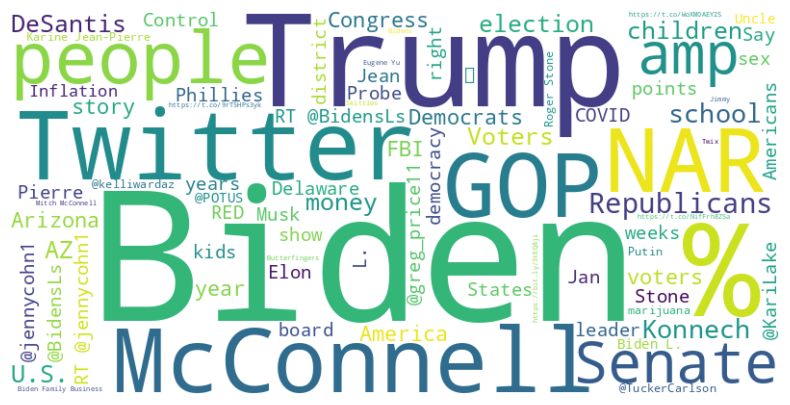

People: Counter({'Biden': 15, 'McConnell': 3, 'Twitter': 3, 'Biden L.': 2, 'Roger Stone': 2, 'Karine Jean-Pierre': 2, 'Biden Family Business': 2, 'Mitch McConnell': 2, 'Eugene Yu': 2, 'Very Unfavorables': 1, 'Jean-Pierre': 1, 'Jenna Ellis': 1, 'Rudy Giuliani': 1, '@greg_price11': 1, 'Louis Gohmert': 1, 'Clarence Thomas': 1, 'Mike Pence': 1, 'Randi Weingarten': 1, 'Elon Musk': 1, 'Debbie Wasserman Schultz': 1, 'Joe Biden': 1, 'Uncle': 1, '@POTUS': 1, '@TuckerCarlson': 1, 'Jacob Engels': 1, 'Evan McMullin': 1, 'Tucker Carlson': 1, 'Tim Ryan': 1, 'marijuana': 1, '@kelliwardaz': 1, "Elon Musk's": 1, 'Gisele Fetterman': 1, 'Putin': 1, 'Ron DeSantis': 1, 'https://t.co/WoXM0AEY2S': 1, 'Stacey Abrams': 1, 'Jeffrey Epstein': 1, 'https://t.co/9rT5HPs3yk': 1, 'https://t.co/NifFrh8ZSa': 1, 'Laura Kelly': 1, 'https://t.co/3IU0YuGVsK https://t.co/bW5SfTKUAG': 1, 'Biden L. https://t.co/FfL1Itkst2': 1, 'Twix': 1, 'Skittles': 1, 'Butterfingers': 1, 'Taylor Swift': 1, 'Jimmy': 1, 'https://bit.ly/3tEQ8ji

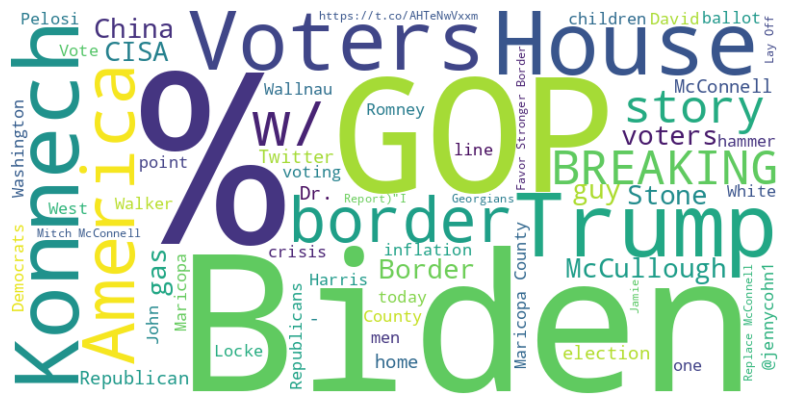

People: Counter({'Biden': 6, 'Favor Stronger Border': 2, 'Replace McConnell': 2, 'Mitch McConnell': 2, 'Lay Off': 2, 'John Kerry': 2, 'Walker Lead': 2, 'Stephen Richer': 2, 'McCullough': 2, 'Roger Stone': 2, 'https://t.co/AHTeNwVxxm': 1, 'Tim Ryan': 1, 'Herschel Walker': 1, 'https://t.co/pWBcvjilR6': 1, 'Tucker Carlson': 1, 'Georgians': 1, 'Vijaya Gadde': 1, 'Trump': 1, 'Bob Casey': 1, "John Fetterman's": 1, 'Kamala Harris': 1, 'Joe Biden': 1, 'Biden L.': 1, 'Romney': 1, 'Mitt Romney': 1, 'Paul Bedard': 1, 'RT @KristiNoem': 1, 'Jamie': 1, 'Report)"I': 1, 'Harris': 1, 'https://twitter.com/Rasmussen_Poll/status/1578483416286101504': 1, 'Very Likely': 1, 'Voting MachinesBy': 1, 'Emerald Robinson': 1, 'Trafalgar': 1, 'Milo': 1, 'w/ Kanye West': 1, 'Jacob Engels': 1, '@kimguilfoyle': 1, 'Raphael Warnock': 1, 'Martin Luther King Jr.': 1, 'Bannon': 1, 'QT @adamwren': 1, 'Favor Stronger Border Enforcement': 1, 'Greg Locke': 1, 'Jake Tapper': 1, 'Wtf': 1, 'David DePape': 1, 'David': 1, 'Klain':

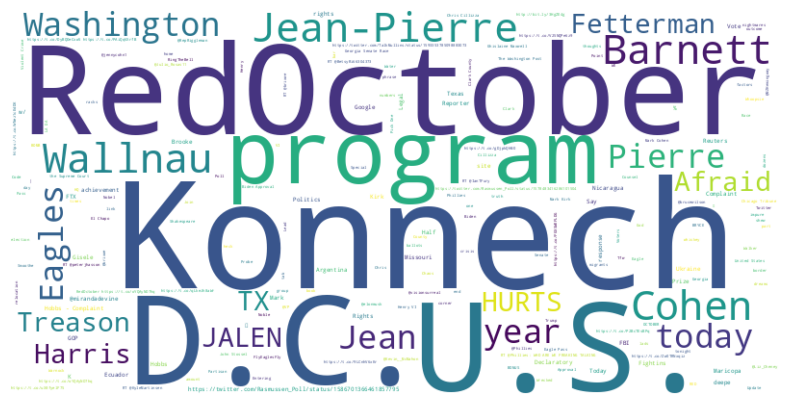

People: Counter({'Jean-Pierre': 3, 'Treason': 1, 'Henry VI': 1, 'Harris': 1, 'Chris Cillizza': 1, 'JALEN': 1, 'RT @brixwe': 1, 'Biden Approval': 1, 'https://t.co/DyBQOeCxw5 https://t.co/PAiQqVXrfB': 1, 'Barnett': 1, 'Afraid': 1, 'https://twitter.com/Rasmussen_Poll/status/1578483416286101504': 1, 'Mark Kirk': 1, 'Mark Cohen': 1, 'Cohen': 1, 'Ghislaine Maxwell': 1, 'Pick One': 1, 'Violent Crime': 1, 'Fetterman': 1, 'Join': 1, 'John Stossel': 1, 'http://bit.ly/3HgZE4g': 1})

Organizations: Counter({'Konnech': 3, 'Hobbs - Complaint': 2, 'Wallnau': 1, 'RT @Phillies: WHO ARE WE FREAKING TALKING': 1, 'Eagle Pass': 1, 'TX': 1, 'HURTS': 1, 'https://twitter.com/Rasmussen_Poll/status/1586701366461857795': 1, 'RedOctober https://t.co/oYQAyNO7hq': 1, 'Wrecked': 1, 'Georgia Senate Race': 1, '@mirandadevine': 1, 'RT @IanTFury': 1, 'FBI': 1, 'RedOctober': 1, 'LA DA': 1, 'The Washington Post': 1, 'RT @peterjhasson': 1, 'Chicago Tribune': 1, 'GOP': 1, 'FTX': 1, 'Reuters': 1, 'El Chapo': 1, 'RT @KyleMart

In [11]:
# Describe findings from this

import spacy
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# List of texts to analyze
human_domain = [x for x in human_selected_msgs]
gpt_domain = [x for x in gpt_selected_msgs]
null_domain = [x for x in null_prompts]

def domain_analysis(texts):
    # Initialize Counters for each domain element
    people_counter = Counter()
    organizations_counter = Counter()
    locations_counter = Counter()
    subjects_counter = Counter()

    for text in texts:
        doc = nlp(text)

        # Extract and count entities
        for ent in doc.ents:
            if ent.label_ == "PERSON":
                people_counter[ent.text] += 1
            elif ent.label_ == "ORG":
                organizations_counter[ent.text] += 1
            elif ent.label_ in {"GPE", "LOC"}:
                locations_counter[ent.text] += 1

        # Extract and count noun phrases (for subjects/topics)
        for token in doc:
            if token.pos_ in {"NOUN", "PROPN"}:
                subjects_counter[token.text] += 1

    # Filter out Twitter generated code:
    for entry in [people_counter, organizations_counter, locations_counter, subjects_counter]:
      for key in ['RT', 'QT']:
        if key in entry:
            del entry[key]

    # Combine all counts into one Counter for the word cloud
    combined_counter = people_counter + organizations_counter + locations_counter + subjects_counter

    # Generate the word cloud from the combined counter
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(combined_counter)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    print("People:", people_counter)
    print("\nOrganizations:", organizations_counter)
    print("\nLocations:", locations_counter)
    print("\nSubjects/Topics:", subjects_counter)

print("HUMAN SELECTED FRAMES")
domain_analysis(human_domain)

print("\n\nGPT SELECTED FRAMES")
domain_analysis(gpt_domain)

print("\n\nNULL SELECTED FRAMES")
domain_analysis(null_domain)


In [18]:
"""WEEK OF OCT 24TH"""

import re
import math
import spacy
from collections import Counter


# Load English model for Spacy (for Dependency Parsing)
nlp = spacy.load('en_core_web_sm')

# Utility functions
def count_syllables(word):
    vowels = "aeiouy"
    word = word.lower()
    if word[0] in vowels:
        syllables = 1
    else:
        syllables = 0
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            syllables += 1
    if word.endswith("e"):
        syllables -= 1
    if syllables == 0:
        syllables = 1
    return syllables

def count_complex_words(text):
    words = text.split()
    return sum(1 for word in words if count_syllables(word) >= 3)

# 1. Automated Readability Index (ARI)
def automated_readability_index(text):
    words = len(re.findall(r'\w+', text))
    sentences = len(re.findall(r'[.!?]', text))
    characters = len(re.findall(r'\S', text))
    if words == 0 or sentences == 0:
        return 0
    return round(4.71 * (characters / words) + 0.5 * (words / sentences) - 21.43, 2)

# 2. Dale-Chall Readability Formula
DALE_CHALL_SIMPLE_WORDS = set(line.strip() for line in open("words.txt"))  # Load simple words list
def dale_chall_readability(text):
    words = re.findall(r'\w+', text)
    sentences = len(re.findall(r'[.!?]', text))
    difficult_words = sum(1 for word in words if word.lower() not in DALE_CHALL_SIMPLE_WORDS)
    difficult_percent = difficult_words / len(words) * 100
    if sentences == 0:
      return 0;
    raw_score = 0.1579 * difficult_percent + 0.0496 * (len(words) / sentences)
    return round(raw_score + 3.6365 if difficult_percent > 5 else raw_score, 2)

# 3. Gunning Fog Index
def gunning_fog_index(text):
    words = len(re.findall(r'\w+', text))
    sentences = len(re.findall(r'[.!?]', text))
    complex_words = count_complex_words(text)
    if words == 0 or sentences == 0:
        return 0
    return 0.4 * ((words / sentences) + 100 * (complex_words / words))

# 4. SMOG Index
def smog_index(text):
    sentences = len(re.findall(r'[.!?]', text))
    polysyllabic_words = count_complex_words(text)
    if sentences == 0:
        return 0
    return round(1.0430 * math.sqrt(polysyllabic_words * (30 / sentences)) + 3.1291, 2)

# 5. Lexical Density
def lexical_density(text):
    words = re.findall(r'\w+', text)
    doc = nlp(text)
    content_words = [token for token in doc if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']]
    if len(words) == 0:
        return 0
    return len(content_words) / len(words)

# 6. Syntactic Complexity using Dependency Parse Trees
def syntactic_complexity(text):
    doc = nlp(text)
    sentences = list(doc.sents)
    sentence_lengths = [len(sent) for sent in sentences]
    avg_sentence_length = sum(sentence_lengths) / len(sentences)

    # Tree depth (approximate using sentence length)
    avg_tree_depth = sum(len([token for token in sent if token.dep_ != 'punct']) for sent in sentences) / len(sentences)

    # Count subordinate clauses
    sub_clauses = sum(1 for token in doc if token.dep_ in ['advcl', 'csubj', 'ccomp', 'relcl'])
    """{
        "avg_sentence_length": avg_sentence_length,
        "avg_tree_depth": avg_tree_depth,
        "subordinate_clauses": sub_clauses
    }"""
    return [avg_sentence_length, avg_tree_depth, sub_clauses]

# Function to analyze text
def analyze_text_complexity(text):
    return {
        "ARI": automated_readability_index(text),
        "Dale-Chall Readability": dale_chall_readability(text),
        "Gunning Fog Index": gunning_fog_index(text),
        "SMOG Index": smog_index(text),
        "Lexical Density": lexical_density(text),
        "Syntactic Complexity": syntactic_complexity(text)
    }

# Example usage

def analyze_text(text, length):
  ARI = 0;
  DC = 0;
  GF = 0;
  SMOG = 0;
  LD = 0;
  ST1 = 0;
  ST2 = 0;
  ST3 = 0;

  for x in text:
    ARI += automated_readability_index(x)
    DC += dale_chall_readability(x)
    GF += gunning_fog_index(x)
    SMOG += smog_index(x)
    LD += lexical_density(x)
    ST1 += syntactic_complexity(x)[0]
    ST2 += syntactic_complexity(x)[1]
    ST3 += syntactic_complexity(x)[2]

  ARI = ARI/length
  DC = DC/length
  GF = GF/length
  SMOG = SMOG/length
  LD = LD/length
  ST1 = ST1/length
  ST2 = ST2/length
  ST3 = ST3/length

  print(f"ARI: {ARI}")
  print(f"Dale-Chall Readability: {DC}")
  print(f"Gunning Fog Index: {GF}")
  print(f"SMOG Index: {SMOG}")
  print(f"Lexical Density: {LD}")
  print(f"Syntactic Complexity, avg_sentence_length: {ST1}")
  print(f"Syntactic Complexity, avg_tree_depth: {ST2}")
  print(f"Syntactic Complexity, subordinate_clauses: {ST3}")

print("HUMAN SELECTED FRAMES")
analyze_text(human_selected_msgs, len(human_selected_msgs))
print("\nGPT SELECTED FRAMES")
analyze_text(gpt_selected_msgs, len(gpt_selected_msgs))
print("\nNULL SELECTED FRAMES")
analyze_text(null_prompts, len(null_prompts))

HUMAN SELECTED FRAMES
ARI: 10.031764705882352
Dale-Chall Readability: 19.549411764705884
Gunning Fog Index: 12.039183510283086
SMOG Index: 11.156029411764706
Lexical Density: 0.3782458722698313
Syntactic Complexity, avg_sentence_length: 17.182352941176475
Syntactic Complexity, avg_tree_depth: 15.188602941176468
Syntactic Complexity, subordinate_clauses: 2.0

GPT SELECTED FRAMES
ARI: 10.619523809523812
Dale-Chall Readability: 20.14984126984128
Gunning Fog Index: 12.136697096174416
SMOG Index: 11.278253968253965
Lexical Density: 0.38760472556059267
Syntactic Complexity, avg_sentence_length: 16.320975056689342
Syntactic Complexity, avg_tree_depth: 14.133049886621311
Syntactic Complexity, subordinate_clauses: 1.8412698412698412

NULL SELECTED FRAMES
ARI: 9.211304347826088
Dale-Chall Readability: 18.226956521739133
Gunning Fog Index: 8.93249689505853
SMOG Index: 8.337173913043479
Lexical Density: 0.3430598814931158
Syntactic Complexity, avg_sentence_length: 12.129710144927534
Syntactic Comp